In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib
import json
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.linear_model as lm
from matplotlib.pylab import (
    figure,
    grid,
    legend,
    loglog,
    semilogx,
    show,
    subplot,
    title,
    xlabel,
    ylabel,
)
from scipy.io import loadmat
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
# from dtuimldmtools import rlr_validate
# from dtuimldmtools import mcnemar
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

In [2]:
df = pd.read_csv("C:\\Users\\brandon\\Downloads\\Algerian_forest_fires_dataset_UPDATE.csv",skiprows=[0,124,125,126,170], sep=',')
df = pd.get_dummies(df, columns=['Classes']) #make class 1 / k
G = df.drop('Classes_not_fire', axis=1)
#Remove the day
G = G.drop('day', axis=1)
G = G.drop('year', axis=1)
G = G.drop('month', axis=1)

#G = G.rename(columns={'Temperature': 'Temp'})
G = G.rename(columns={'Classes_fire': 'Fire'})
g = G
y = g["Fire"]
X = g.drop('Fire', axis=1)
attributeNames1 = X.columns[:]
attributeNames = [name for name in attributeNames1]
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = y.values
classNames = [1,0]
N, M = X.shape

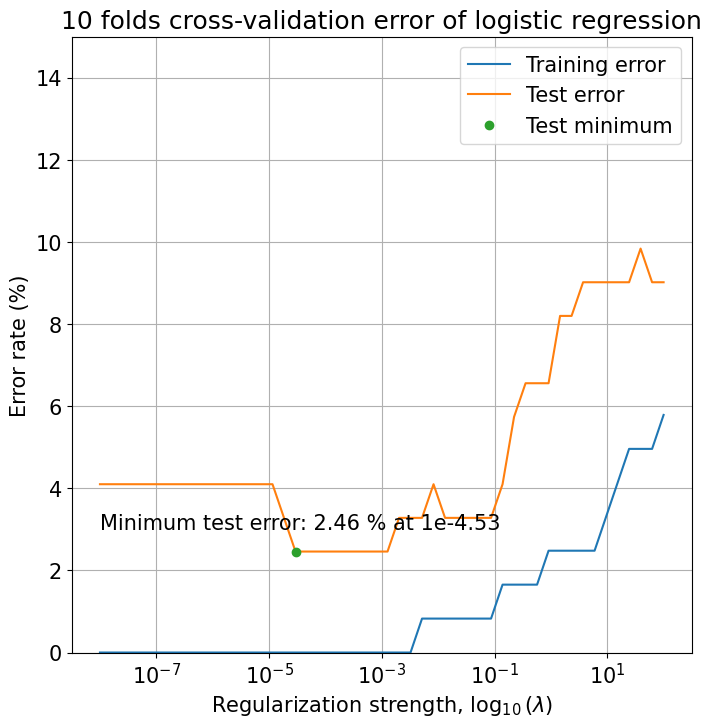

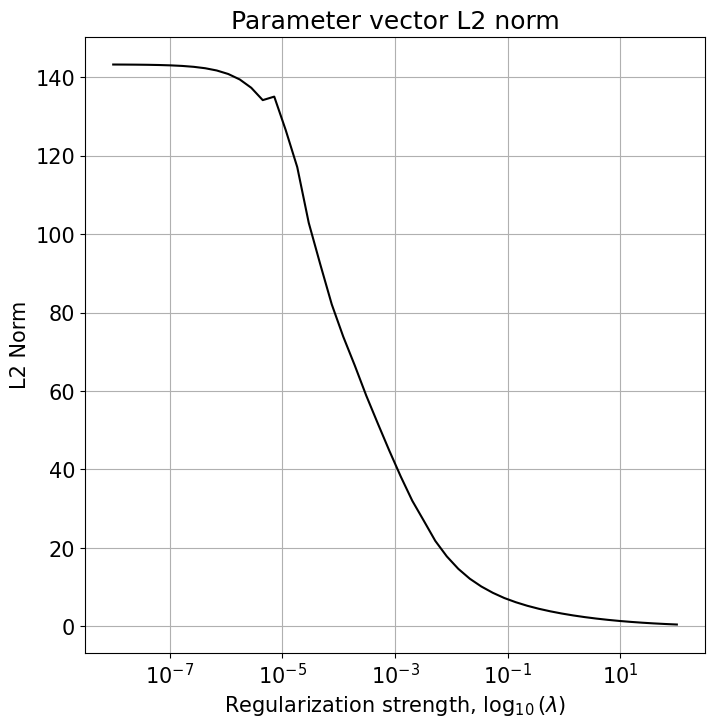

In [3]:
# Classification 2:Logistic regression
font_size = 15
plt.rcParams.update({"font.size": font_size})
# Create crossvalidation partition for evaluation
# using stratification and 95 pct. split between training and test
K = 10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y,random_state=42)
# Try to change the test_size to e.g. 50 % and 99 % - how does that change the
# effect of regularization? How does differetn runs of  test_size=.99 compare
# to eachother?

# Standardize the training and set set based on training set mean and std
# mu = np.mean(X_train, 0)
# sigma = np.std(X_train, a0)
# 
# X_train = (X_train - mu) / sigma
# X_test = (X_test - mu) / sigma

# Fit regularized logistic regression model to training data to predict
lambda_interval = np.logspace(-8, 2, 50)
train_error_rate = np.zeros(len(lambda_interval))
test_error_rate = np.zeros(len(lambda_interval))
coefficient_norm = np.zeros(len(lambda_interval))
for k in range(0, len(lambda_interval)):
    mdl = LogisticRegression(penalty="l2", C=1 / lambda_interval[k])
    mdl.fit(X_train, y_train)
    y_train_est = mdl.predict(X_train).T
    y_test_est = mdl.predict(X_test).T

    train_error_rate[k] = np.sum(y_train_est != y_train) / len(y_train)
    test_error_rate[k] = np.sum(y_test_est != y_test) / len(y_test)

    w_est = mdl.coef_[0]
    coefficient_norm[k] = np.sqrt(np.sum(w_est**2))

min_error = np.min(test_error_rate)
opt_lambda_idx = np.argmin(test_error_rate)
opt_lambda = lambda_interval[opt_lambda_idx]

plt.figure(figsize=(8, 8))
# plt.plot(np.log10(lambda_interval), train_error_rate*100)
# plt.plot(np.log10(lambda_interval), test_error_rate*100)
# plt.plot(np.log10(opt_lambda), min_error*100, 'o')
plt.semilogx(lambda_interval, train_error_rate * 100)
plt.semilogx(lambda_interval, test_error_rate * 100)
plt.semilogx(opt_lambda, min_error * 100, "o")
plt.text(
    1e-8,
    3,
    "Minimum test error: "
    + str(np.round(min_error * 100, 2))
    + " % at 1e"
    + str(np.round(np.log10(opt_lambda), 2)),
)
plt.xlabel("Regularization strength, $\log_{10}(\lambda)$")
plt.ylabel("Error rate (%)")
plt.title("10 folds cross-validation error of logistic regression")
plt.legend(["Training error", "Test error", "Test minimum"], loc="upper right")
plt.ylim([0, 15])
plt.grid()
plt.show()

plt.figure(figsize=(8, 8))
plt.semilogx(lambda_interval, coefficient_norm, "k")
plt.ylabel("L2 Norm")
plt.xlabel("Regularization strength, $\log_{10}(\lambda)$")
plt.title("Parameter vector L2 norm")
plt.grid()
plt.show()


table1_Log = dict(zip(lambda_interval,test_error_rate))
with open('table1_Log .json', 'w') as json_file:
     json.dump(table1_Log , json_file)

In [4]:
# Classification 2:Baseline
y_base = pd.Series([1] * 243)
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
score = []
for train_index, test_index in k_fold.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        scores = np.sum(y_base[test_index] != y_test)/len(y_test)
        score.append(scores)
Error_base = score
print(Error_base)

[0.52, 0.4, 0.28, 0.5833333333333334, 0.375, 0.5, 0.4166666666666667, 0.375, 0.2916666666666667, 0.625]


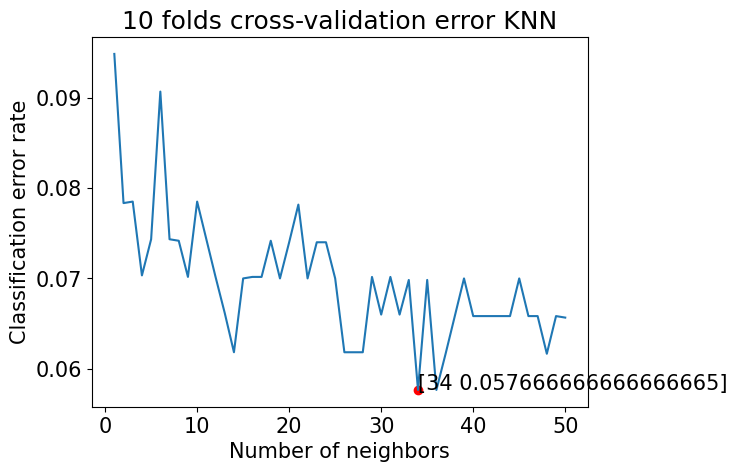

Best K: 34
Best K value: 0.057666666666666665


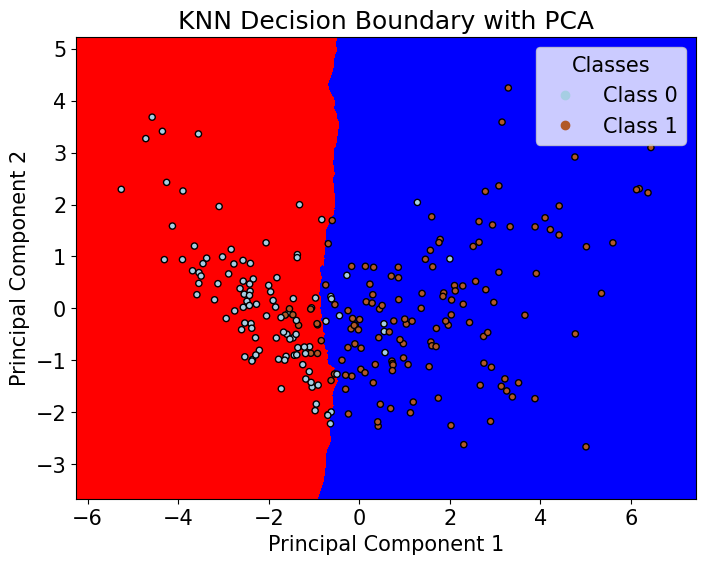

In [5]:
# Classification 2:KNN
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
k_values = list(range(1, 51))  
k_scores = np.zeros((len(k_values)))
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    fold_scores = []
    for train_index, val_index in k_fold.split(X, y):
        X_train, X_test = X[train_index], X[val_index]
        y_train, y_test = y[train_index], y[val_index]
        knn.fit(X_train, y_train)
        y_est = knn.predict(X_test)
        score = np.sum(y_est != y_test)/len(y_test)
        fold_scores.append(score)
    k_scores[k-1] = np.mean(fold_scores)
plt.plot(np.arange(1,51), k_scores)
min_value = min(k_scores)
min_index = np.argmin(k_scores) + 1
plt.scatter(min_index, min_value, color='red')
mark = '['+str(min_index)+' '+str(min_value)+']'
plt.annotate(mark,xy=[min_index,min_value],xytext=(min_index,min_value))
xlabel("Number of neighbors")
ylabel("Classification error rate")
plt.title('10 folds cross-validation error KNN')
plt.show()
print("Best K:",min_index)
print("Best K value:", min_value)
a = [x for x in range(1,51)]
table1_KNN = dict(zip(a,k_scores))
# with open('table1_KNN.json', 'w') as json_file:
#      json.dump(table1_KNN, json_file)
# plot
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

knn = KNeighborsClassifier(n_neighbors=min_index)
knn.fit(X_pca, y)

h = 0.02  
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])


Z = Z.reshape(xx.shape)
cmap_light = ListedColormap(['red', 'blue'])
plt.figure(figsize=(8, 6))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.Paired, edgecolor='k', s=20)
plt.legend(handles = scatter.legend_elements()[0], labels=['Class 0', 'Class 1'], title='Classes')
plt.xlim(xx.min(), xx.max())
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("KNN Decision Boundary with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [6]:
#Classification 3: two_level cross validation KNN
#k from 25-45
KNN_K = [x for x in range(1,51)] 
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # outer cv = 10
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  # inner cv = 5
# store the generalization error E^test_i
test_error_list_KNN = []
best_k = []
test_pred_KNN = []
y_true = []
# outer loop split the dataset into par and test
for train_index, test_index in outer_cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    cv_scores = {} #store the generalization error of different k in D_val
    for C in KNN_K: 
        val_s_error_list = []  # store the error of D_val with one k
        # inner loop split the par dataset into train and val
        KNN = KNeighborsClassifier(n_neighbors=C) # KNN
        for inner_train_index, inner_val_index in inner_cv.split(X_train, y_train): 
            X_inner_train, X_inner_val = X_train[inner_train_index], X_train[inner_val_index]
            y_inner_train, y_inner_val = y_train[inner_train_index], y_train[inner_val_index]
            KNN.fit(X_inner_train, y_inner_train) # train data
            y_test_pred = KNN.predict(X_inner_val) # predict
            #  store the error of D_val with one k in one kind of split
            val_s_error = np.sum(y_test_pred != y_inner_val) / len(y_test_pred)
            #  store the error of D_val with one k in one kind of split
            val_s_error_list.append(val_s_error) 
        # calculate the average accurancy of cross validation(all kinds of split)
        mean_val_s_error_list = sum(val_s_error_list) / len(val_s_error_list)
        # store the generalization error of different k in D_val
        cv_scores[C] = mean_val_s_error_list
    #choose the best k
    best_C = min(cv_scores, key=cv_scores.get)
    # retest
    best_KNN = KNeighborsClassifier(n_neighbors=best_C)
    best_KNN.fit(X_train, y_train)
    y_pred_KNN = best_KNN.predict(X_test)
    #calculate and store the generalization error in D_test
    test_error = np.sum(y_test != y_pred_KNN) / len(y_test)
    test_error_list_KNN.append(test_error)
    best_k.append(best_C)
    test_pred_KNN.append(y_pred_KNN)
    y_true.append(y_test)
print(test_error_list_KNN)
print(best_k)
# print(test_pred_KNN[[test_error_list.index(min(test_error_list))][0]])
# pred_KNN = test_pred_KNN[[test_error_list.index(min(test_error_list))][0]]
# print(test_pred_KNN[0])
# pred_KNN = test_pred_KNN[0]
table2_KNN = dict(zip(best_k,test_error_list_KNN))
# with open('table2_KNN.json', 'w') as json_file:
#      json.dump(table2_KNN, json_file)


[0.08, 0.24, 0.08, 0.08333333333333333, 0.08333333333333333, 0.041666666666666664, 0.08333333333333333, 0.041666666666666664, 0.0, 0.08333333333333333]
[9, 2, 12, 27, 15, 17, 23, 32, 42, 42]


In [50]:
##Classification 3: two_level cross validation logistic regression
lambda_interval = np.logspace(-6,0, 25)
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
test_error_list_log = []
best_lambda = []
test_pred_log = []
for train_index, test_index in outer_cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    cv_scores = []
    cv_scores_index = []
    # for C in range(0, len(lambda_interval)):
    for C in lambda_interval:
        val_s_error_list = []  
        logistic_regression = LogisticRegression(C=C, solver='liblinear')
        # logistic_regression = LogisticRegression(penalty="l2", C=1 / lambda_interval[k])
        for inner_train_index, inner_val_index in inner_cv.split(X_train, y_train):
            X_inner_train, X_inner_val = X_train[inner_train_index], X_train[inner_val_index]
            y_inner_train, y_inner_val = y_train[inner_train_index], y_train[inner_val_index]
            logistic_regression.fit(X_inner_train, y_inner_train)
            y_test_pred = logistic_regression.predict(X_inner_val)
            val_s_error = np.sum(y_test_pred != y_inner_val) / len(y_test_pred)
            val_s_error_list.append(val_s_error)
        mean_val_s_error_list = sum(val_s_error_list) / len(val_s_error_list)
        cv_scores.append(mean_val_s_error_list)
        cv_scores_index.append(C)
    cv_scores_dict = dict(zip(cv_scores_index,cv_scores))
    best_C = min(cv_scores_dict, key=cv_scores_dict.get)
    best_log = LogisticRegression(C=best_C, solver='liblinear')
    # best_log = LogisticRegression(penalty="l2", C=1/best_C)
    best_log.fit(X_train, y_train)
    print("Weights of the model with highest accuracy:", best_log.coef_)
    y_pred_log = best_log.predict(X_test)
    test_accuracy = np.sum(y_test != y_pred_log) / len(y_test)
    test_error_list_log.append(test_accuracy)
    best_lambda.append(best_C)
    test_pred_log.append(y_pred_log)
print(test_error_list_log)
print(best_lambda)
# print(test_pred_log[[test_error_list.index(min(test_error_list))][0]])
# pred_log = test_pred_log[[test_error_list.index(min(test_error_list))][0]]
# print(test_pred_log[0])
# pred_log = test_pred_log[0]
table2_log = dict(zip(best_lambda,test_error_list_log))
# with open('table2_log.json', 'w') as json_file:
#      json.dump(table2_log, json_file)

Weights of the model with highest accuracy: [[ 0.1150236   0.11806859 -0.19942636 -0.48327741  2.81857451 -0.4214511
   0.22215567  2.34907464  0.28294817  1.76977963]]
Weights of the model with highest accuracy: [[ 0.29707004  0.28490979 -0.09316556  0.01423858  2.28904211  0.05440277
   0.18759444  1.81461945  0.10212268  1.33152626]]
Weights of the model with highest accuracy: [[ 0.16058379  0.25585629 -0.08086099 -0.0320247   2.36553508 -0.09704288
   0.01582615  1.83353236  0.22747942  1.36672831]]
Weights of the model with highest accuracy: [[ 0.08424004  0.20726323 -0.12617331  0.20406638  2.87877609 -0.31904318
   0.12840503  2.25063941  0.28312201  1.67362085]]
Weights of the model with highest accuracy: [[ 0.14993902  0.2226588  -0.08057552 -0.06972002  2.3596984  -0.17081734
   0.09573857  1.8370721   0.21764369  1.37360832]]
Weights of the model with highest accuracy: [[-0.02787181  0.2619331  -0.16405191  0.27968543  2.90927901 -0.26710398
   0.06147205  2.3095858   0.2971

In [50]:
lambda_interval = np.logspace(-6,0, 25)
import math

math.log10(0.5623413251903491)
10**(-0.25)

0.5623413251903491

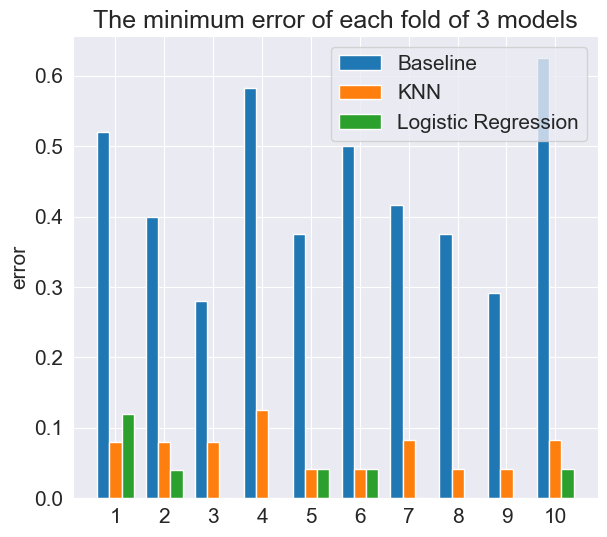

In [89]:
plt.figure(figsize=(23, 6))

first = Error_base
second = test_error_list_KNN
third = test_error_list_log
labels = [i for i in range(1,11)]

plt.subplot(132)
x = np.arange(len(labels))  
width = 0.25  

plt.bar(x - width, first, width, label = 'Baseline')
plt.bar(x, second, width, label='KNN')
plt.bar(x + width, third, width, label='Logistic Regression')
plt.ylabel('error')
plt.title('The minimum error of each fold of 3 models')

plt.xticks(x, labels=labels)
plt.legend()
plt.show()


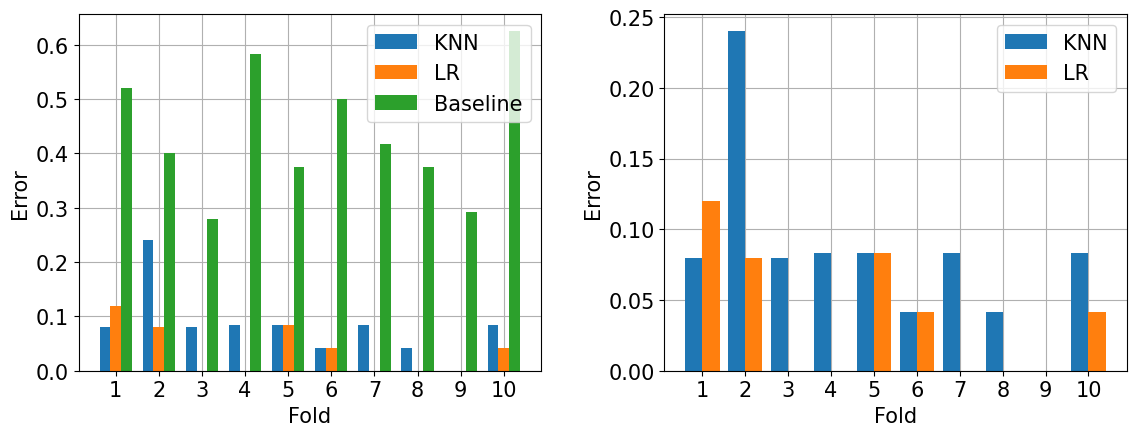

In [20]:
plt.subplots(1, 2, figsize=(12, 5))
plt.subplot(1,2,1)
plt.grid(zorder=0)

first = test_error_list_KNN
second = test_error_list_log
third = Error_base
labels = [i for i in range(1,11)]
x = np.arange(len(labels))
width = 0.25 
plt.bar(x - width, first, width, label = 'KNN', zorder=2)
plt.bar(x, second, width, label='LR', zorder=2)
plt.bar(x + width, third, width, label='Baseline', zorder=2)
plt.ylabel('Error')
plt.xlabel('Fold')
#plt.title('The minimum error of each fold of 3 models')
plt.xticks(x, labels=labels)
plt.legend()

plt.subplot(1,2,2)
plt.grid(zorder=0)

first = test_error_list_KNN
second = test_error_list_log
#third = Error_base
labels = [i for i in range(1,11)]
x = np.arange(len(labels))
width = 0.4 
plt.bar(x - width/2, first, width, label = 'KNN', zorder=2)
plt.bar(x + width/2, second, width, label='LR', zorder=2)
#plt.bar(x + width, third, width, label='Baseline', color='green')
plt.ylabel('Error')
plt.xlabel('Fold')
#plt.title('The minimum error of each fold of 3 models')
plt.xticks(x, labels=labels)
plt.legend()

plt.tight_layout(pad=2)
plt.savefig('comparison_test_error.pdf', bbox_inches='tight')
plt.show()

In [13]:
#Classification 4
lambda_interval = np.logspace(-6, 1, 25)
CV = model_selection.LeaveOneOut()
cv_scores_log = {}
cv_scores = []
cv_scores_index = []
for C in lambda_interval:
    test_error_list = []
    logistic_regression = LogisticRegression(C=C, solver='liblinear')
    for train_index, test_index in CV.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        logistic_regression.fit(X_train, y_train)
        y_test_pred = logistic_regression.predict(X_test)
        test_error = np.sum(y_test_pred != y_test) / len(y_test_pred)
        test_error_list.append(test_error)
    mean_val_s_error_list = sum(test_error_list) / len(test_error_list)
    cv_scores.append(mean_val_s_error_list)
    cv_scores_index.append(C)
cv_scores_dict = dict(zip(cv_scores_index,cv_scores))
best_C = min(cv_scores_dict, key=cv_scores_dict.get)
best_log = LogisticRegression(C=best_C, solver='liblinear')
y_pred_log = []
y_pred_err_log = []
for train_index, test_index in CV.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    best_log.fit(X_train, y_train)
    y_test_pred = best_log.predict(X_test)
    test_error = np.sum(y_test_pred != y_test) / len(y_test_pred)
    y_pred_log.append(y_test_pred)
    y_pred_err_log.append(test_error)
mean_val_error = sum(y_pred_err_log) / len(y_pred_err_log)
y_pred_log = np.concatenate(y_pred_log)
print(y_pred_log)
print(len(y_pred_log))
print(mean_val_error)

[0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0 0 0 1 1 0
 1 0 0 0 0 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1
 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1
 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 0 0 1 1 1
 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 0 0 0]
243
0.0205761316872428


In [14]:
KNN_K = [x for x in range(25,46)]
CV = model_selection.LeaveOneOut()
cv_scores_KNN = {} 
for C in KNN_K:
    test_error_list = []  
    KNN = KNeighborsClassifier(n_neighbors=C)
    for train_index, test_index in CV.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        KNN.fit(X_train, y_train)
        y_test_pred = KNN.predict(X_test)
        test_error = np.sum(y_test_pred != y_test) / len(y_test_pred)
        test_error_list.append(test_error)
    mean_val_s_error_list = sum(test_error_list) / len(test_error_list)
    cv_scores_KNN[C] = mean_val_s_error_list
best_C = min(cv_scores_KNN, key=cv_scores_KNN.get)
best_log = KNeighborsClassifier(n_neighbors=best_C)
y_pred_KNN = []
y_pred_err_KNN = []
for train_index, test_index in CV.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    best_log.fit(X_train, y_train)
    y_test_pred = best_log.predict(X_test)
    test_error = np.sum(y_test_pred != y_test) / len(y_test_pred)
    y_pred_KNN.append(y_test_pred)
    y_pred_err_KNN.append(test_error)
mean_val_error = sum(y_pred_err_KNN) / len(y_pred_err_KNN)
y_pred_KNN = np.concatenate(y_pred_KNN)
print(y_pred_KNN)
print(len(y_pred_KNN))
print(mean_val_error)

[0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1
 1 0 0 1 0 1 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1
 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1
 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0]
243
0.06172839506172839


In [ ]:
alpha =0.1
[thetahat_1, CI_1, p_1] = mcnemar(y, y_pred_KNN, y_pred_log, alpha=alpha)
[thetahat_2, CI_2, p_2] = mcnemar(y, y_pred_KNN, y_base, alpha=alpha)
[thetahat_3, CI_3, p_3] = mcnemar(y, y_pred_log, y_base, alpha=alpha)
print("theta = theta_A-theta_B point estimate", thetahat_1, " CI: ", CI_1, "p-value", p_1)
print("theta = theta_A-theta_B point estimate", thetahat_2, " CI: ", CI_2, "p-value", p_2)
print("theta = theta_A-theta_B point estimate", thetahat_3, " CI: ", CI_3, "p-value", p_3)

In [35]:
# Fit regularized logistic regression model to training data to predict
lambda_interval = np.logspace(-8, 2, 50)
w_rlr = np.empty((M, len(lambda_interval)))
train_error_rate = np.zeros(len(lambda_interval))
test_error_rate = np.zeros(len(lambda_interval))
coefficient_norm = np.zeros(len(lambda_interval))
for k in range(0, len(lambda_interval)):
    mdl = LogisticRegression(penalty="l2", C=1 / lambda_interval[k])
    mdl.fit(X_train, y_train)
    y_train_est = mdl.predict(X_train).T
    y_test_est = mdl.predict(X_test).T

    train_error_rate[k] = np.sum(y_train_est != y_train) / len(y_train)
    test_error_rate[k] = np.sum(y_test_est != y_test) / len(y_test)

    w_est = mdl.coef_[0]
    w_rlr[:, k] = w_est
    coefficient_norm[k] = np.sqrt(np.sum(w_est**2))

min_error = np.min(test_error_rate)
opt_lambda_idx = np.argmin(test_error_rate)
opt_lambda = lambda_interval[opt_lambda_idx]

print("waigts LR class 2")
opt_lambda_w_est = w_rlr[:, opt_lambda_idx]
for m in range(M):
    print("{:>15} {:>15}".format(attributeNames[m], np.round(opt_lambda_w_est[m], 2)))

waigts LR class 2
           Temp           -0.84
             Rh            0.05
             Ws           -0.42
           Rain            2.38
           FFMC            8.11
            DMC           -3.53
             DC            2.45
            ISI            8.57
            BUI            -0.6
            FWI            5.94
